In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"
# %pip install --upgrade --quiet  langchain-community arxiv
# %pip install -qU duckduckgo-search langchain-community
# %pip install pymupdf

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")


Please provide your OPENAI_API_KEY ········


In [3]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## 1. Web Search agent

In [4]:
from langchain_community.tools import DuckDuckGoSearchResults
search = DuckDuckGoSearchResults(output_format="list")

from langgraph.prebuilt import create_react_agent

web_search_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[search],
    prompt=(
        "You are a web_search agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with web search related tasks.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="web_search_agent",
)

for chunk in web_search_agent.stream(
    {"messages": [{"role": "user", "content": "Latest weather in Chandigarh"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: web_search_agent
Tool Calls:
  duckduckgo_results_json (call_KILBCBF8WUsA97GVJyf7UC5L)
 Call ID: call_KILBCBF8WUsA97GVJyf7UC5L
  Args:
    query: latest weather Chandigarh




/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ad4687d0830>


Update from node tools:


================================= Tool Message =================================
Name: duckduckgo_results_json

[{"snippet": "5 days ago · Chandigarh Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the Chandigarh area.", "title": "Chandigarh, India Weather Conditions | Weather Underground", "link": "https://www.wunderground.com/weather/in/chandigarh"}, {"snippet": "Aug 11, 2024 · Be prepared with the most accurate 10-day forecast for Chandigarh, Chandigarh, India with highs, lows, chance of precipitation from The Weather Channel and Weather.com", "title": "10-day weather forecast for Chandigarh, Chandigarh, India - The …", "link": "https://weather.com/en-NA/weather/tenday/l/Chandigarh+Chandigarh+India?canonicalCityId=cfc82f24ce4d2cb39aac706481f3d037bcc634b26db47a1867479fb272ffd081"}, {"snippet": "3 days ago · Check out the weather forecast for Chandigarh now and how it

### 2. Arxiv agent

In [5]:
import os
from langchain.tools import Tool
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

arxiv_wrapper = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=5000)

def search_arxiv_summaries(query: str) -> str:
    """
    Use this tool to find summaries of Arxiv papers on a specific topic.
    It returns a formatted string of the top results' titles, authors, and abstracts.
    This is best for getting a quick overview of research on a topic.
    """
    print(f"\nEXECUTING TOOL: Searching Arxiv for summaries of '{query}'...")
    return arxiv_wrapper.run(query)

def read_arxiv_paper_content(query: str) -> str:
    """
    Use this tool when you need to read the full content of a specific Arxiv paper to answer a question.
    You can use a keyword search or a specific Arxiv ID.
    It downloads the paper's PDF, extracts the full text, and returns it.
    Use this when summaries are not enough to answer the user's question.
    """
    print(f"\nEXECUTING TOOL: Reading full Arxiv paper for '{query}'...")
    single_paper_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=15000)
    docs = single_paper_wrapper.load(query)
    if docs:
        return docs[0].page_content
    return "Could not find a paper for that query."

tools = [
    Tool(
        name="Search Arxiv Summaries",
        func=search_arxiv_summaries,
        description="Useful for when you need to find and summarize academic papers on a specific topic from Arxiv. The input should be a search query."
    ),
    Tool(
        name="Read Arxiv Paper Content",
        func=read_arxiv_paper_content,
        description="Useful for when you need to read the full text of a specific paper to find details not in the summary. The input can be a specific Arxiv ID or a search query."
    )
]

arxiv_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[search_arxiv_summaries, read_arxiv_paper_content],
    prompt=(
        "You are an expert research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="arxiv_agent",
)

## 3. Writer agent

In [7]:
writer_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[],
    prompt=("You are an expert report writer. Your role is to synthesize the information provided in the conversation history from the other agents. Review the research from the Web Search Agent and the Arxiv Agent, then write a comprehensive, well-structured report that addresses the original user request. Do not perform any research yourself; only use the provided information."),
    name="writer_agent"
)

## 4. Supervisor agent with`langgraph-supervisor`

In [8]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[web_search_agent, arxiv_agent, writer_agent],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a web search agent. Assign websearch-related tasks to this agent\n"
        "- an arxiv agent. Assign tasks related to research to this agent\n"
        "- a expert writer that writes in a formal manner. Assign task like summarizing and writing to this."
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

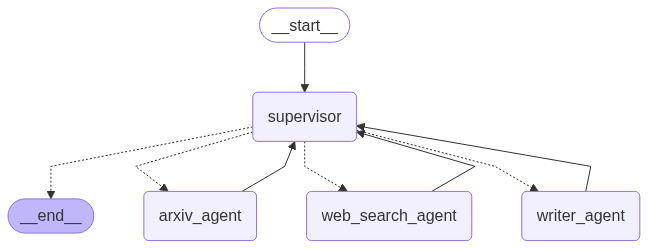

In [9]:
from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [10]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find upcoming AI conferences in USA. What are the latest papers on arxiv related to image dehazing?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_web_search_agent

Successfully transferred to web_search_agent




/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ad468453150>


Update from node web_search_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_arxiv_agent

Successfully transferred to arxiv_agent



EXECUTING TOOL: Searching Arxiv for summaries of 'image dehazing'...


/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/arxiv.py:105: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  ).results()
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ad46859bbd0>


Update from node arxiv_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_writer_agent

Successfully transferred to writer_agent


Update from node writer_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Here is a formal report summarizing the requested information:

---

**Upcoming AI Conferences in the USA (2025):**
1. AI Conferences: The Top AI Events to Attend in 2025 – [bitcot.com](https://www.bitcot.com/top-ai-conferences-events/)
2. Top AI Conferences to Attend in USA in 2025 – [CTO Mag

## 5. Create supervisor from scratch

In [33]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,  # (1)!
            # highlight-next-line
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            # highlight-next-line
            graph=Command.PARENT,  # (3)!
        )

    return handoff_tool

#web_search_agent, arxiv_agent, writer_agent
# Handoffs
assign_to_web_search_agent = create_handoff_tool(
    agent_name="web_search_agent",
    description="Assign task to a web search agent.",
)

assign_to_arxiv_agent = create_handoff_tool(
    agent_name="arxiv_agent",
    description="Assign task to arxiv research agent.",
)

assign_to_writer_agent = create_handoff_tool(
    agent_name="writer_agent",
    description="Assign task to our writer agent.",
)

supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_web_search_agent, assign_to_arxiv_agent, assign_to_writer_agent],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a web search agent. Assign websearch-related tasks to this agent\n"
        "- an arxiv agent. Assign tasks related to research papers to this agent\n"
        "- a expert writer that writes in a formal manner"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

from langgraph.graph import END

supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent, destinations=("arxiv_agent", "web_search_agent", "writer_agent", END))
    .add_node(arxiv_agent)
    .add_node(web_search_agent)
    .add_node(writer_agent)
    .add_edge(START, "supervisor")
    .add_edge("web_search_agent", "supervisor")
    .add_edge("arxiv_agent", "supervisor")
    .add_edge("writer_agent", "supervisor")
    .compile()
)

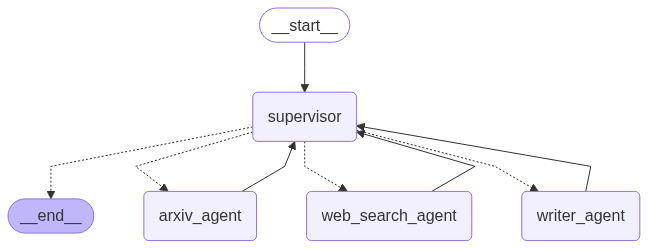

In [35]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

With the multi-agent graph created, let's now run it!

In [38]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What are dates of NeurIPS 2025 and Name the title of the latest paper by sergey levine?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_web_search_agent

Successfully transferred to web_search_agent




/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ad4683584b0>


Update from node web_search_agent:


================================== Ai Message ==================================
Name: web_search_agent

- NeurIPS 2025 will be held from December 2nd to December 7th, 2025 at the San Diego Convention Center. [Source](https://neurips.cc/Conferences/2025/Dates)
- The latest paper by Sergey Levine is titled "Steering Your Generalists: Improving Robotic Foundation Model Deployment via Value-Guided Action Ranking." [Source](https://arxiv.org/abs/2410.13816)


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_writer_agent

Successfully transferred to writer_agent


Update from node writer_agent:


================================== Ai Message ==================================
Name: writer_agent

The NeurIPS 2025 conference will take place from Tuesday, December 2nd, 2025, to Sunday, December 7th, 2025, at the San Diego Convention Center. 

The latest paper by Sergey Levine i